Training FCN2 via SGLD...
Epoch 0 | Loss: 0.7824
Epoch 5000 | Loss: 0.0121
Epoch 10000 | Loss: 0.0103
Epoch 15000 | Loss: 0.0076
Epoch 20000 | Loss: 0.0081
Epoch 25000 | Loss: 0.0119
Epoch 30000 | Loss: 0.0080
Epoch 35000 | Loss: 0.0102
Epoch 40000 | Loss: 0.0040
Epoch 45000 | Loss: 0.0047
Epoch 50000 | Loss: 0.0063
Epoch 55000 | Loss: 0.0108
Epoch 60000 | Loss: 0.0095
Epoch 65000 | Loss: 0.0116
Epoch 70000 | Loss: 0.0094
Epoch 75000 | Loss: 0.0132
Epoch 80000 | Loss: 0.0100
Epoch 85000 | Loss: 0.0106
Epoch 90000 | Loss: 0.0066
Epoch 95000 | Loss: 0.0114


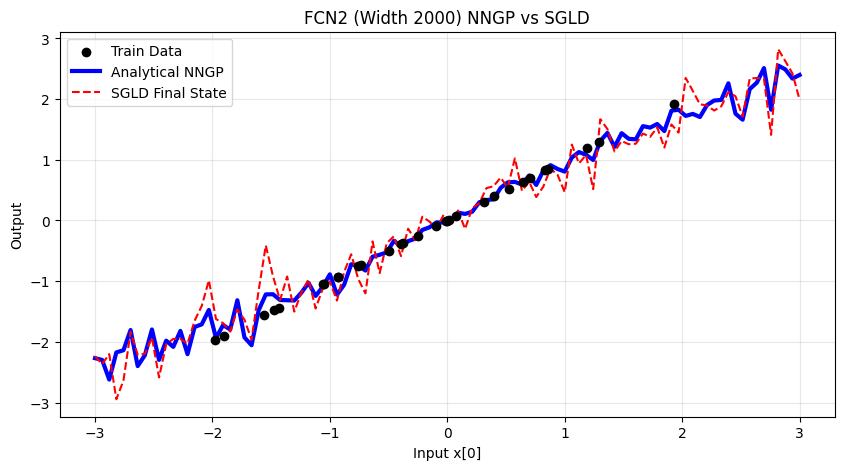

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math



# --- 2. Corrected SGLD Optimizer ---
class SGLDOptimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3, temperature=1.0):
        defaults = dict(lr=lr, temperature=temperature)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            T = group['temperature']
            noise_std = math.sqrt(2 * lr * T)

            for p in group['params']:
                if p.grad is None: continue
                
                # NNGP Prior Matching:
                # We want prior variance sigma^2 = 1/fan_in
                # In SGLD, weight decay lambda must be T / sigma^2
                # Therefore, weight_decay = T * fan_in
                fan_in = p.shape[1] if p.ndim > 1 else 1
                weight_decay = T * fan_in
                
                # Update: w = w - lr*(grad + wd*w) + noise
                d_p = p.grad + weight_decay * p
                p.add_(d_p, alpha=-lr)
                p.add_(torch.randn_like(p), alpha=noise_std)

# --- 3. Model and Data ---
class FCN2_ERF(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        # 2 hidden layers implies 3 weight matrices (W1, W2, W3)
        self.fc1 = nn.Linear(d, h, bias=False)
        self.fc2 = nn.Linear(h, 1, bias=False)

    def forward(self, x):
        x = torch.erf(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate Synthetic Data
D_IN = 10
P = 30# Number of samples
torch.manual_seed(42)
X_train = torch.randn(P, D_IN).to(torch.device('cuda:1'))
Y_train = X_train[:, 0:1] #* 1.0  # Simple linear target

# --- 4. Training ---
HIDDEN = 2000
model = FCN2_ERF(D_IN, HIDDEN).to(torch.device('cuda:1'))
# Initialize weights with 1/fan_in variance to start near the prior
for p in model.parameters():
    fan_in = p.shape[1] if p.ndim > 1 else 1
    nn.init.normal_(p, std=math.sqrt(1.0/fan_in))

# Temperature 1.0 works well; reduction='sum' is required for SGLD logic
criterion = nn.MSELoss(reduction='sum')
optimizer = SGLDOptimizer(model.parameters(), lr=1e-6, temperature=0.02)

print("Training FCN2 via SGLD...")
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = criterion(model(X_train), Y_train)
    loss.backward()
    optimizer.step()

    
    if epoch % 5000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()/P:.4f}")


# --- 1. Analytical Arcsin NNGP Kernel (The Ground Truth) ---
def arcsin_step(K):
    """One layer of Arcsin (erf) NNGP kernel evolution."""
    diag = torch.sqrt(1 + 2 * torch.diagonal(K))
    denom = diag[:, None] * diag[None, :]
    arg = torch.clamp(2 * K / denom, -1.0, 1.0)
    return (2 / torch.pi) * torch.arcsin(arg)

def compute_nngp_prediction(X_train, Y_train, X_test):
    """
    Computes exact NNGP inference for FCN2.
    Matches the Arcsin kernel with sigma_w^2=1, sigma_b^2=0.
    """
    X_all = torch.cat([X_train, X_test], dim=0)
    d = X_all.shape[1]
    
    # Layer 0 (Input)
    K = (X_all @ X_all.T) / d
   
    K = arcsin_step(K)
    
    # GP Inference: y_pred = K_test_train @ (K_train_train + noise*I)^-1 @ y_train
    # Note: SGLD samples the posterior. For NNGP, noise is usually small.
    P = len(Y_train)
    K_tt = K[:P, :P]
    K_xt = K[P:, :P]
    
    # Small epsilon for numerical stability
    L = torch.linalg.cholesky(K_tt + 0.01* torch.eye(P).to(torch.device('cuda:1')))
    alpha = torch.cholesky_solve(Y_train, L)
    return K_xt @ alpha

    
# --- 5. Comparison and Plotting ---
X_test = torch.linspace(-3, 3, 100).view(-1, 1).to(torch.device('cuda:1'))
# Create test data with same background noise as training data
X_test_full = torch.randn(100, D_IN).to(torch.device('cuda:1')) # Background noise in all 10 dims
X_test_full[:, 0] = X_test.flatten() # Override the first dim with our sweep


# Analytical Prediction
y_nngp = compute_nngp_prediction(X_train, Y_train, X_test_full)

# Empirical Prediction (Average over multiple Langevin samples or one final)
model.eval()
with torch.no_grad():
    y_sgld = model(X_test_full)
X_train_np = X_train.cpu().numpy()
Y_train_np = Y_train.cpu().numpy()
y_nngp = y_nngp.cpu().numpy()
y_sgld = y_sgld.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.scatter(X_train_np[:, 0], Y_train_np, color='black', label='Train Data', zorder=3)
plt.plot(X_test.cpu().numpy(), y_nngp, label='Analytical NNGP', color='blue', linewidth=3)
plt.plot(X_test.cpu().numpy(), y_sgld, label='SGLD Final State', color='red', linestyle='--')
plt.title(f"FCN2 (Width {HIDDEN}) NNGP vs SGLD")
plt.xlabel("Input x[0]")
plt.ylabel("Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


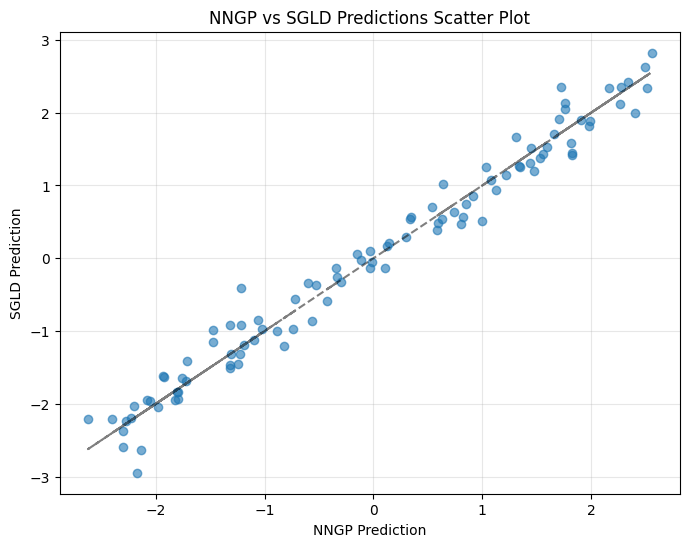

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(y_nngp, y_sgld, 'o', alpha=0.6)
plt.xlabel("NNGP Prediction")
plt.ylabel("SGLD Prediction")
plt.plot(y_nngp, y_nngp, 'k--', alpha=0.5)  # y=x reference line
plt.title("NNGP vs SGLD Predictions Scatter Plot")
plt.grid(True, alpha=0.3)
plt.show()

Network 1, Epoch 0 | Loss: 1.7636
Network 1, Epoch 5000 | Loss: 0.0121
Network 1, Epoch 10000 | Loss: 0.0103
Network 1, Epoch 15000 | Loss: 0.0110
Network 1, Epoch 20000 | Loss: 0.0135
Network 1, Epoch 25000 | Loss: 0.0091
Network 1, Epoch 30000 | Loss: 0.0104
Network 1, Epoch 35000 | Loss: 0.0086
Network 1, Epoch 40000 | Loss: 0.0085
Network 1, Epoch 45000 | Loss: 0.0155
Network 1, Epoch 50000 | Loss: 0.0096
Network 1, Epoch 55000 | Loss: 0.0076
Network 1, Epoch 60000 | Loss: 0.0122
Network 1, Epoch 65000 | Loss: 0.0112
Network 1, Epoch 70000 | Loss: 0.0102
Network 1, Epoch 75000 | Loss: 0.0113
Network 1, Epoch 80000 | Loss: 0.0075
Network 1, Epoch 85000 | Loss: 0.0060
Network 1, Epoch 90000 | Loss: 0.0120
Network 1, Epoch 95000 | Loss: 0.0109
Network 1: corr=0.9917, mse=1.4524e-02


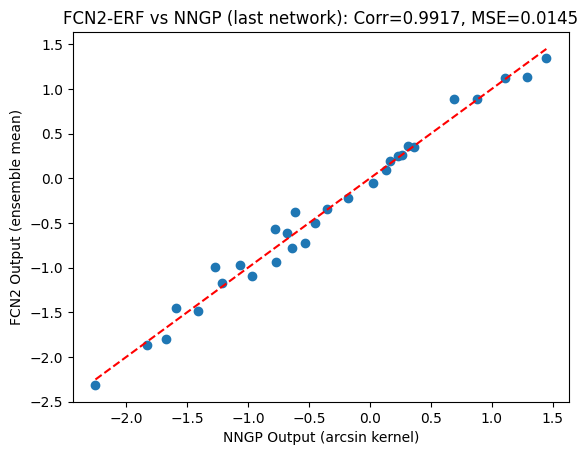

In [ ]:
import sys
sys.path.append('../lib')
from FCN2Network import FCN2NetworkEnsembleErf

def arcsin_kernel(X1, X2):
    # Implements the 2-layer Arcsin (erf) NNGP kernel
    d = X1.shape[1]
    K = (X1 @ X2.T) / d
    # First layer
    diag1 = torch.sqrt(1 + 2 * torch.diagonal(K, 0))
    denom1 = diag1[:, None] * diag1[None, :]
    K1 = (2 / np.pi) * torch.asin(torch.clamp(2 * K / denom1, -1.0, 1.0))
   
    return K1

def nngp_predict(X_train, Y_train, X_test, ridge=0.01):
    K = arcsin_kernel(torch.cat([X_train, X_test]), torch.cat([X_train, X_test]))
    P = X_train.shape[0]
    K_tt = K[:P, :P]
    K_xt = K[P:, :P]
    L = torch.linalg.cholesky(K_tt + ridge * torch.eye(P, device=K.device))
    alpha = torch.cholesky_solve(Y_train, L)
    return K_xt @ alpha

num_networks = 1
results = []
d = 10
P = 30
N = 2000
lr = 1e-5
ens = 1
kappa = 0.01
T = 2 * kappa 
epochs = 100000
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
for net_idx in range(num_networks):
    # New dataset for each network
    X = torch.randn(P, d, device=device)
    Y = X[:, 0].unsqueeze(1)

    # New model for each dataset
    model = FCN2NetworkEnsembleErf(
        d=d, n1=N, P=P, ens=ens,
        weight_initialization_variance=(1/d, 1/(N * chi)),
        device=device
    )

    # Langevin training loop
    for epoch in range(epochs):
        model.zero_grad()
        out = model(X)  # (P, ens)
        loss = ((out - Y) ** 2).sum()
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                noise = torch.randn_like(p) * (2 * lr * T) ** 0.5
                p.add_(p.grad, alpha=-lr)
                p.add_(noise)
        if epoch % 5000 == 0:
            print(f"Network {net_idx+1}, Epoch {epoch} | Loss: {loss.item()/P:.4f}")

    # Analytical NNGP prediction (arcsin kernel)
    with torch.no_grad():
        model_out = model(X).mean(dim=1).cpu().numpy()
        nngp_out = nngp_predict(X, Y, X).cpu().numpy().squeeze()

    corr = np.corrcoef(model_out, nngp_out)[0, 1]
    mse = np.mean((model_out - nngp_out) ** 2)
    results.append((corr, mse))
    print(f"Network {net_idx+1}: corr={corr:.4f}, mse={mse:.4e}")

# Optionally, plot the last network's results
plt.scatter(nngp_out, model_out)
plt.xlabel("NNGP Output (arcsin kernel)")
plt.ylabel("FCN2 Output (ensemble mean)")
plt.title(f"FCN2-ERF vs NNGP (last network): Corr={corr:.4f}, MSE={mse:.4f}")
plt.plot([nngp_out.min(), nngp_out.max()], [nngp_out.min(), nngp_out.max()], 'r--')
plt.show()

In [ ]:
__file__ = '/home/akiva/FCNX-Ensembling/journal/Erf NNGP.ipynb'
num_networks = 1
mf_results = []
d = 10
P = 30
N = 2000
lr = 1e-5
ens = 1
kappa = 0.01
chi = N/10
T = 2 * kappa / chi
epochs = 2_000_000
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
import json
import os
Xinf = torch.randn(1000, d, device=device)
eigs_over_time = torch.zeros((num_networks, d, epochs // 5000 + 1), device=device)
for net_idx in range(num_networks):
    # New dataset for each network
    torch.manual_seed(net_idx)
    X = torch.randn(P, d, device=device)
    Y = X[:, 0].unsqueeze(1)

    # New model for each dataset
    model_mf_i = FCN2NetworkEnsembleErf(
        d=d, n1=N, P=P, ens=ens,
        weight_initialization_variance=(1/d, 1/(N * chi)),
        device=device
    )
      
    # model_mf_i.load_state_dict(torch.load(os.path.join(models_dir, f"fcn2_erf_mfi_net{k+1}.pth")))

    # Langevin seed
    torch.manual_seed(net_idx + 1000)
    # Langevin training loop
    for epoch in range(epochs):
        model.zero_grad()
        out = model_mf_i(X)  # (P, ens)
        loss = ((out - Y) ** 2).sum()
        loss.backward()
        with torch.no_grad():
            for n, p in model_mf_i.named_parameters():
                noise = torch.randn_like(p) * (2 * lr * T) ** 0.5
                p.add_(p.grad, alpha=-lr)
                # Add weight decay term for MF-I
                fan_in = p.shape[1] if p.ndim > 1 else 1
                # If preactivation, no chi factor
                if n == 'W0':
                    weight_decay = T * fan_in
                else:
                    weight_decay = T * chi * fan_in
                p.add_( - lr * weight_decay * p)
                p.add_(noise)
        if epoch % 5000 == 0:
            print(f"Network {net_idx+1}, Epoch {epoch} | Loss: {loss.item()/P:.4f}")
            ls = torch.tensor(model_mf_i.H_eig(Xinf,Xinf))
            eigs_over_time[net_idx, :, epoch // 5000] = ls

            print(f"Leading eigenvalue of H: {ls[0]:.4f}")

    # Analytical NNGP prediction (arcsin kernel)
    with torch.no_grad():
        model_out = model_mf_i(X).mean(dim=1).cpu().numpy()
        nngp_out = nngp_predict(X, Y, X).cpu().numpy().squeeze()
    # Save model results
    # Get absoulte directory of current script
    current_dir = os.path.dirname(os.path.abspath(__file__))
    # Make a models directory if it doesn't exist
    models_dir = os.path.join(current_dir, "models")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    torch.save(model_mf_i.state_dict(), os.path.join(models_dir, f"fcn2_erf_mfi_net{net_idx+1}.pth"))
    # Save model config
    config = {'d': d, 'n1': N, 'P': P, 'ens': ens, 'chi': chi, 'loss': loss.item()/P, 'data_seed': net_idx, 'langevin_seed': net_idx + 1000}
    with open(os.path.join(models_dir, f"fcn2_erf_mfi_net{net_idx+1}_config.json"), 'w') as f:
        json.dump(config, f)

    corr = np.corrcoef(model_out, nngp_out)[0, 1]
    mse = np.mean((model_out - nngp_out) ** 2)
    mf_results.append((corr, mse))
    print(f"Network {net_idx+1}: corr={corr:.4f}, mse={mse:.4e}")

# Optionally, plot the last network's results
plt.scatter(nngp_out, model_out)
plt.xlabel("NNGP Output (arcsin kernel)")
plt.ylabel("FCN2 Output (ensemble mean)")
plt.title(f"FCN2-ERF vs NNGP (last network): Corr={corr:.4f}, MSE={mse:.4f}")
plt.plot([nngp_out.min(), nngp_out.max()], [nngp_out.min(), nngp_out.max()], 'r--')
plt.show()


Network 1, Epoch 0 | Loss: 0.9436
Leading eigenvalue of H: 0.0394


/tmp/ipykernel_2924051/381627810.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ls = torch.tensor(model_mf_i.H_eig(Xinf,Xinf))


Network 1, Epoch 5000 | Loss: 0.0562
Leading eigenvalue of H: 0.0222
Network 1, Epoch 10000 | Loss: 0.0083
Leading eigenvalue of H: 0.0509
Network 1, Epoch 15000 | Loss: 0.0039
Leading eigenvalue of H: 0.0660
Network 1, Epoch 20000 | Loss: 0.0032
Leading eigenvalue of H: 0.0721
Network 1, Epoch 25000 | Loss: 0.0027
Leading eigenvalue of H: 0.0748
Network 1, Epoch 30000 | Loss: 0.0049
Leading eigenvalue of H: 0.0761
Network 1, Epoch 35000 | Loss: 0.0124
Leading eigenvalue of H: 0.0770
Network 1, Epoch 40000 | Loss: 0.0060
Leading eigenvalue of H: 0.0776
Network 1, Epoch 45000 | Loss: 0.0069
Leading eigenvalue of H: 0.0780
Network 1, Epoch 50000 | Loss: 0.0056
Leading eigenvalue of H: 0.0784
Network 1, Epoch 55000 | Loss: 0.0033
Leading eigenvalue of H: 0.0786
Network 1, Epoch 60000 | Loss: 0.0027
Leading eigenvalue of H: 0.0788
Network 1, Epoch 65000 | Loss: 0.0045
Leading eigenvalue of H: 0.0789
Network 1, Epoch 70000 | Loss: 0.0128
Leading eigenvalue of H: 0.0790
Network 1, Epoch 7500

KeyboardInterrupt: 

Network 1: corr=0.9966, mse=6.1379e-03


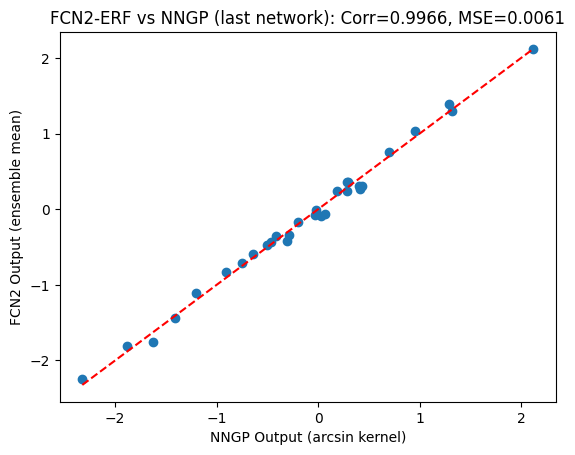

In [97]:
# Analytical NNGP prediction (arcsin kernel)
with torch.no_grad():
    model_out = model_mf_i(X).mean(dim=1).cpu().numpy()
    nngp_out = nngp_predict(X, Y, X).cpu().numpy().squeeze()
# Save model results
# Get absoulte directory of current script
current_dir = os.path.dirname(os.path.abspath(__file__))
# Make a models directory if it doesn't exist
models_dir = os.path.join(current_dir, "models")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
torch.save(model_mf_i.state_dict(), os.path.join(models_dir, f"fcn2_erf_mfi_net{net_idx+1}.pth"))
# Save model config
config = {'d': d, 'n1': N, 'P': P, 'ens': ens, 'chi': chi, 'loss': loss.item()/P, 'data_seed': net_idx, 'langevin_seed': net_idx + 1000}
with open(os.path.join(models_dir, f"fcn2_erf_mfi_net{net_idx+1}_config.json"), 'w') as f:
    json.dump(config, f)

corr = np.corrcoef(model_out, nngp_out)[0, 1]
mse = np.mean((model_out - nngp_out) ** 2)
mf_results.append((corr, mse))
print(f"Network {net_idx+1}: corr={corr:.4f}, mse={mse:.4e}")

# Optionally, plot the last network's results
plt.scatter(nngp_out, model_out)
plt.xlabel("NNGP Output (arcsin kernel)")
plt.ylabel("FCN2 Output (ensemble mean)")
plt.title(f"FCN2-ERF vs NNGP (last network): Corr={corr:.4f}, MSE={mse:.4f}")
plt.plot([nngp_out.min(), nngp_out.max()], [nngp_out.min(), nngp_out.max()], 'r--')
plt.show()


In [ ]:
# Print out the model's eigenvalues against the theory
theory_eigenvalues = []
for k in range(1, N+1):

In [ ]:
__file__ = '/home/akiva/FCNX-Ensembling/journal/Erf NNGP.ipynb'

NameError: name '__file__' is not defined

In [101]:
theory = {
    "P": 30,
    "lWT": 0.6137001702831154,
    "b": 0.4244131815783876,
    "n1": 2000,
    "lJ": 0.194017792951809,
    "delta": 0,
    "chi": 2000,
    "lWP": 0.1,
    "lk": 0.9965727239329513,
    "kappa": 0.01,
    "lkp": 6.358802373540584e-14,
    "lJP": 0.042441318157875364,
    "d": 10
}
Xinf = torch.randn((3000,d), dtype=torch.float32, device='cuda:1')
exp_eig = []
for k in range(num_networks):
    model_mf_i = FCN2NetworkEnsembleErf(
        d=d, n1=N, P=P, ens=ens,
        weight_initialization_variance=(1/d, 1/(N * chi)),
        device=device
    )
    model_mf_i.load_state_dict(torch.load(os.path.join(models_dir, f"fcn2_erf_mfi_net{k+1}.pth")))
    eigs = model_mf_i.H_eig(Xinf,Xinf)
    exp_eig.append(eigs.cpu().numpy())

In [78]:
list(range(d))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

<BarContainer object of 10 artists>

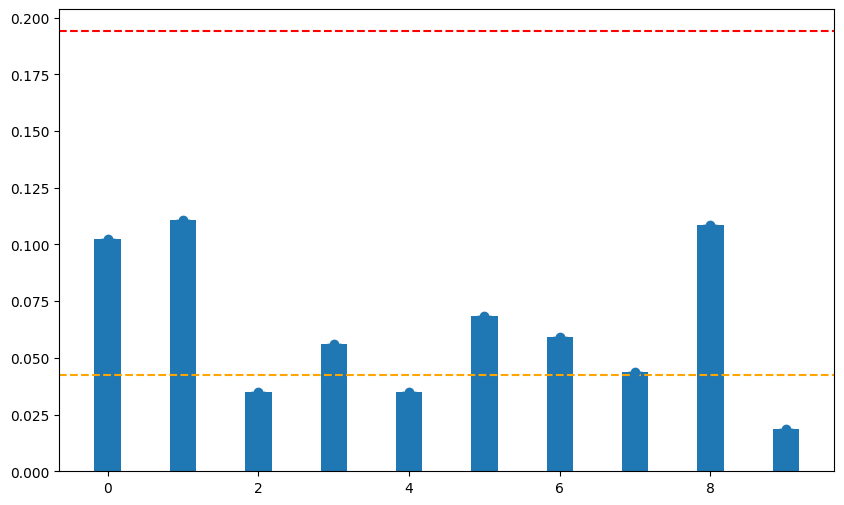

In [102]:
# Bar plot
plt.figure(figsize=(10,6))
width = 0.35
exp_eig_np = np.mean(np.array(exp_eig), axis=0)
exp_eig_np_std = np.std(np.array(exp_eig), axis=0)
exp_eig_np_sderr = exp_eig_np_std / np.sqrt(num_networks)
plt.errorbar(range(d), exp_eig_np, yerr=exp_eig_np_sderr, fmt='o', label='Empirical Eigenvalues', capsize=5)
plt.axhline(y=theory["lJ"], color='r', linestyle='--', label='Theoretical Eigenvalues')
plt.axhline(y=theory["lJP"], color='orange', linestyle='--', label='Theoretical Eigenvalues')
plt.bar(range(d), exp_eig_np, width=width, label='Empirical Eigenvalues')